### LightGBMを試す


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'a_mean_age':                  'int8',
 'a_std_age':                   'float16',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int32',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int32',
 'perceived_colour_value_id':   'int32',
 'perceived_colour_master_id':  'int32',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'is_for_male':                 'bool',
 'is_for_female':               'bool',
 'is_for_mama':                 'bool',
 'c_mean_price':                'float16',
 'c_std_price':                 'float16',
 'a_mean_price':                'float16',     
 'c_cv_total':                  'int32',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'a_cv_recent_ranking':         'int16',
 'c_mean_sales_channel_id':     'float16',
 'a_mean_sales_channel_id':     'float16',
 'c_mean_is_for_male':          'float16',
 'a_mean_is_for_male':          'float16',
 'c_mean_is_for_female':        'float16',
 'a_mean_is_for_female':        'float16',
 'c_mean_is_for_mama':          'float16',
 'diff_dat_last_buy':           'int16',
 'a_mean_is_for_mama':          'float16',
 'ca_index_group_no_num':       'int32',
 'index_group_no_similarity':   'float32',
 'ca_index_code_num':           'int32',
 'index_code_similarity':       'float32',
 'ca_product_group_no_num':     'int32',
 'product_group_no_similarity': 'float32',
 'buy_same_before':             'int16',
 'buy_same_before_recent':      'int16',
 'buy_same_last_week':          'int16',
 'delta_mean_price':            'float16',
 'delta_mean_age':              'int8',
 'delta_mean_sales_channel_id': 'float16',
 'delta_mean_is_for_male':      'float16',
 'delta_mean_is_for_female':    'float16',
 'delta_mean_is_for_mama':      'float16'
 }

In [4]:
# train data
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09']
#train_date_list = ['2020-09-09', '2020-09-16']
#train_date_list = ['2020-09-09']
train_date_list = ['2020-09-16']
negative_num = 100
train_list = [dd.read_csv(f'./train_{date}_{negative_num}.csv', dtype=input_type).compute() for date in train_date_list]

In [5]:
train = pd.concat([train_list[0]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
#valid = train_list[3].reset_index(drop=True)

In [6]:
# 毎回同じbaselineと比較するため固定
valid = dd.read_csv(f'./train_2020-09-16_200.csv', dtype=input_type).compute() 
valid = valid.reset_index(drop=True)

In [7]:
train

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-9223100958908512198,372860072,False,True,False,0,4,35,303672,0.028214,...,0.000000,0,0,0,0.015053,1,0.619141,0.000000,0.000000,0.130493
1,-9223100958908512198,408649007,False,True,False,0,4,35,303672,0.028214,...,0.000000,0,0,0,0.015190,-2,0.839844,0.000000,0.000000,0.130493
2,-9223100958908512198,554598001,False,True,False,0,4,35,303672,0.028214,...,0.391304,0,0,0,0.011940,-1,0.609375,0.000000,0.000000,0.130493
3,-9223100958908512198,555102001,False,True,False,0,4,35,303672,0.028214,...,0.391304,0,0,0,0.002392,1,0.030273,0.000000,0.000000,0.130493
4,-9223100958908512198,598755002,False,True,False,0,4,35,303672,0.028214,...,0.391304,0,0,0,0.015312,0,0.300781,-1.000000,1.000000,0.130493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965398,9223141695752178477,928206001,False,True,True,0,4,19,135002,0.024078,...,0.200000,0,0,0,-0.009445,-18,-0.866211,0.266602,-0.266602,0.000000
6965399,9223141695752178477,928835001,False,True,True,0,4,19,135002,0.024078,...,0.133333,0,0,0,0.015869,-17,-0.306641,0.266602,-0.266602,0.000000
6965400,9223141695752178477,930380001,False,True,True,0,4,19,135002,0.024078,...,0.200000,0,0,0,-0.009216,-26,-0.866211,0.266602,-0.266602,0.000000
6965401,9223141695752178477,933989002,False,True,True,0,4,19,135002,0.024078,...,0.000000,0,0,0,-0.017822,-12,-0.866211,0.266602,-0.266602,0.000000


In [8]:
valid

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-9223100958908512198,372860001,False,True,False,0,4,35,303672,0.028214,...,0.000000,0,0,0,0.015259,2,0.699219,0.000000,0.000000,0.130493
1,-9223100958908512198,372860002,False,True,False,0,4,35,303672,0.028214,...,0.000000,0,0,0,0.016068,1,0.625977,0.000000,0.000000,0.130493
2,-9223100958908512198,524529001,False,True,False,0,4,35,303672,0.028214,...,0.391304,0,0,0,0.012199,1,0.553711,0.000000,0.000000,0.130493
3,-9223100958908512198,556260002,False,True,False,0,4,35,303672,0.028214,...,0.347826,0,0,0,-0.005295,-2,0.023438,0.000000,0.000000,0.130493
4,-9223100958908512198,562245102,False,True,False,0,4,35,303672,0.028214,...,0.347826,0,0,0,-0.003723,0,0.513672,0.000000,0.000000,0.130493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13457186,9223141695752178477,931769003,False,True,True,0,4,19,135002,0.024078,...,0.200000,0,0,0,-0.017776,-14,-0.863281,0.266602,-0.266602,0.000000
13457187,9223141695752178477,933373001,False,True,True,0,4,19,135002,0.024078,...,0.133333,0,0,0,0.015869,-11,0.133789,0.266602,-0.266602,0.000000
13457188,9223141695752178477,936862001,False,True,True,0,4,19,135002,0.024078,...,0.000000,0,0,0,-0.025589,-17,-0.859375,0.266602,-0.266602,0.000000
13457189,9223141695752178477,938804001,False,True,True,0,4,19,135002,0.024078,...,0.200000,0,0,0,-0.040649,-13,0.046875,0.266602,-0.266602,0.000000


In [9]:
del train_list
gc.collect()

0

## Preprocess

In [10]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-9223100958908512198,372860072,False,True,False,0,4,35,303672,0.028214,...,0.000000,0,0,0,0.015053,1,0.619141,0.0,0.0,0.130493
1,-9223100958908512198,408649007,False,True,False,0,4,35,303672,0.028214,...,0.000000,0,0,0,0.015190,-2,0.839844,0.0,0.0,0.130493
2,-9223100958908512198,554598001,False,True,False,0,4,35,303672,0.028214,...,0.391304,0,0,0,0.011940,-1,0.609375,0.0,0.0,0.130493
3,-9223100958908512198,555102001,False,True,False,0,4,35,303672,0.028214,...,0.391304,0,0,0,0.002392,1,0.030273,0.0,0.0,0.130493
4,-9223100958908512198,598755002,False,True,False,0,4,35,303672,0.028214,...,0.391304,0,0,0,0.015312,0,0.300781,-1.0,1.0,0.130493


In [11]:
# queryの準備, customer_idごとにsortする, lightGBMを使うときに必要
query_list_train = train['customer_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid['customer_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [12]:
query_list_train.head()

-9223100958908512198    102
-9223002534477110135    100
-9222810895170663723    102
-9221924794303263774    100
-9221811157628158522    101
Name: customer_id, dtype: int64

In [13]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [14]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

In [15]:
# labelエンコードは前段で済んでいる

## Training

In [16]:
# LightGBM
import lightgbm as lgb

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'ndcg_eval_at': [12],
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
}

num_round = 300

In [17]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

In [18]:
lgb_train

In [19]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval],
                  #callbacks=[early_stopping(10), log_evaluation(10)],
                  early_stopping_rounds=10
                 )
                  

/home/tetsuro/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 68984, total data: 6965403
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7659
[LightGBM] [Info] Number of data points in the train set: 6965403, number of used features: 52
[LightGBM] [Info] Total groups: 68984, total data: 13457191
[1]	train's map@12: 0.091903	valid's map@12: 0.063592
Training until validation scores don't improve for 10 rounds
[2]	train's map@12: 0.110112	valid's map@12: 0.0778988
[3]	train's map@12: 0.1256	valid's map@12: 0.0885291
[4]	train's map@12: 0.131481	valid's map@12: 0.0929875
[5]	train's map@12: 0.135975	valid's map@12: 0.0956817
[6]	train's map@12: 0.140063	valid's map@12: 0.0987938
[7]	train's map@12: 0.141967	valid's map@12: 0.100152
[8]	train's map@12: 0.143992	valid's map@12: 0.101631
[9]	train's map@12: 0.14538

[140]	train's map@12: 0.169369	valid's map@12: 0.118307
[141]	train's map@12: 0.169447	valid's map@12: 0.118336
[142]	train's map@12: 0.169441	valid's map@12: 0.118331
[143]	train's map@12: 0.16959	valid's map@12: 0.118356
[144]	train's map@12: 0.169755	valid's map@12: 0.118367
[145]	train's map@12: 0.169735	valid's map@12: 0.118447
[146]	train's map@12: 0.169767	valid's map@12: 0.11842
[147]	train's map@12: 0.169846	valid's map@12: 0.118588
[148]	train's map@12: 0.169889	valid's map@12: 0.118575
[149]	train's map@12: 0.16994	valid's map@12: 0.118689
[150]	train's map@12: 0.170016	valid's map@12: 0.11866
[151]	train's map@12: 0.170132	valid's map@12: 0.118615
[152]	train's map@12: 0.17013	valid's map@12: 0.118703
[153]	train's map@12: 0.170282	valid's map@12: 0.118704
[154]	train's map@12: 0.170439	valid's map@12: 0.118821
[155]	train's map@12: 0.170427	valid's map@12: 0.118877
[156]	train's map@12: 0.170482	valid's map@12: 0.118941
[157]	train's map@12: 0.170562	valid's map@12: 0.1189

[287]	train's map@12: 0.176018	valid's map@12: 0.122774
[288]	train's map@12: 0.176115	valid's map@12: 0.122773
[289]	train's map@12: 0.176125	valid's map@12: 0.122804
[290]	train's map@12: 0.176137	valid's map@12: 0.122796
[291]	train's map@12: 0.176171	valid's map@12: 0.122828
[292]	train's map@12: 0.17626	valid's map@12: 0.122851
[293]	train's map@12: 0.176305	valid's map@12: 0.122886
[294]	train's map@12: 0.176312	valid's map@12: 0.122825
[295]	train's map@12: 0.176403	valid's map@12: 0.122889
[296]	train's map@12: 0.176411	valid's map@12: 0.122956
[297]	train's map@12: 0.176442	valid's map@12: 0.12296
[298]	train's map@12: 0.176473	valid's map@12: 0.122987
[299]	train's map@12: 0.176461	valid's map@12: 0.122947
[300]	train's map@12: 0.176522	valid's map@12: 0.12299
Did not meet early stopping. Best iteration is:
[300]	train's map@12: 0.176522	valid's map@12: 0.12299


In [20]:
model.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x7fd5d324c670>>

In [21]:
model.best_iteration

300

In [22]:
model.feature_name()

['FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'c_mean_price',
 'c_std_price',
 'c_cv_total',
 'c_cv_recent',
 'c_mean_sales_channel_id',
 'c_mean_is_for_male',
 'c_mean_is_for_female',
 'c_mean_is_for_mama',
 'diff_dat_last_buy',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'is_for_male',
 'is_for_female',
 'is_for_mama',
 'product_group_no',
 'a_mean_price',
 'a_cv_total',
 'a_cv_recent',
 'a_cv_recent_ranking',
 'a_mean_sales_channel_id',
 'a_mean_age',
 'a_std_age',
 'ca_index_group_no_num',
 'index_group_no_similarity',
 'ca_index_code_num',
 'index_code_similarity',
 'ca_product_group_no_num',
 'product_group_no_similarity',
 'buy_same_before',
 'buy_same_before_recent',
 'buy_same_last_week',
 'delta_mean_price',
 'delta_mean_age',
 'delta_mean_

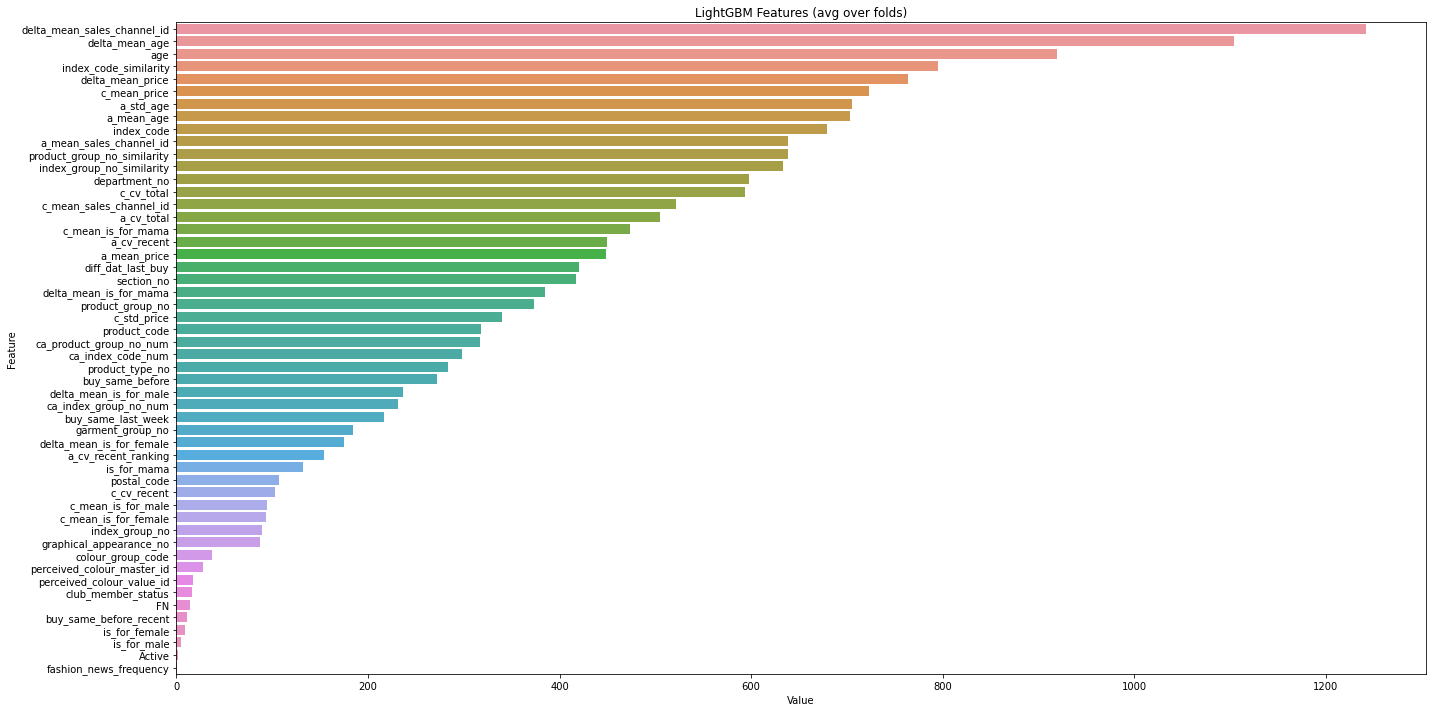

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## test

In [24]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

12997

In [25]:
# test data
Nval = 30
#Nval = 12
test = dd.read_csv(f'./test_{Nval}.csv', dtype=input_type).compute()
test

,customer_id,article_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_std_price,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-2324495172285268445,736530007,True,False,0,4,21,183703,0.023712,0.004795,...,0.5,1,0,1,-0.000462,-9,0.287109,0.0,0.0,0.0
1,-2324495172285268445,770703004,True,False,0,4,21,183703,0.023712,0.004795,...,0.5,1,0,1,-0.005836,-12,0.236328,0.0,0.0,0.0
2,-2324495172285268445,736531006,True,False,0,4,21,183703,0.023712,0.004795,...,0.5,0,0,0,0.014046,-10,0.303711,0.0,0.0,0.0
3,-2324495172285268445,706016001,True,False,0,4,21,183703,0.023712,0.004795,...,0.0,0,0,0,-0.008736,-11,0.154297,0.0,0.0,0.0
4,-2324495172285268445,924243001,True,False,0,4,21,183703,0.023712,0.004795,...,0.5,0,0,0,-0.017792,-15,0.347656,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128344,-4411265289383494801,788575004,False,False,0,2,0,259329,0.050842,0.000000,...,0.0,0,0,0,0.009018,-33,-0.998047,0.0,-1.0,0.0
128345,-4411265289383494801,928206001,False,False,0,2,0,259329,0.050842,0.000000,...,0.0,0,0,0,0.017380,-43,-0.886719,0.0,-1.0,0.0
128346,-4411265289383494801,573085028,False,False,0,2,0,259329,0.050842,0.000000,...,0.0,0,0,0,0.018265,-34,-0.733398,0.0,-1.0,0.0
128347,-4411265289383494801,751471043,False,False,0,2,0,259329,0.050842,0.000000,...,0.0,0,0,0,0.017715,-41,-0.674805,0.0,-1.0,0.0


In [26]:
test.sort_index(inplace=True)

In [27]:
test_id = test[['customer_id', 'article_id']]
test = test.drop(['customer_id', 'article_id'], axis=1)

### prediction

In [28]:
del query_list_train, query_list_valid, lgb_train, lgb_eval, params, feature_imp
gc.collect()

0

In [29]:
test

,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_std_price,c_cv_total,c_cv_recent,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,True,False,0,4,21,183703,0.023712,0.004795,2,0,...,0.500000,1,0,1,-0.000462,-9,0.287109,0.0,0.0,0.0
0,False,False,3,2,69,72794,0.026428,0.010002,5,0,...,0.600000,0,0,0,-0.020416,38,0.095703,0.0,0.0,0.0
0,False,False,3,2,41,119919,0.021164,0.010132,8,0,...,0.250000,0,0,0,-0.012184,6,0.189453,0.0,0.0,0.0
0,False,False,0,2,30,165038,0.019333,0.005890,12,0,...,0.000000,0,0,0,-0.013115,-2,0.154297,0.0,0.0,0.0
0,False,False,0,2,18,318704,0.031952,0.022583,6,0,...,0.666667,0,0,0,0.007465,-18,0.219727,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128512,False,False,3,2,44,333138,0.033875,0.023972,2,0,...,0.000000,0,0,0,0.001041,12,0.432617,0.0,0.0,0.0
128513,False,False,3,2,44,333138,0.033875,0.023972,2,0,...,0.000000,0,0,0,0.001534,7,0.304688,0.0,0.0,0.0
128514,False,False,3,2,44,333138,0.033875,0.023972,2,0,...,0.500000,0,0,0,0.000524,9,0.189453,0.0,0.0,0.0
128515,False,False,3,2,44,333138,0.033875,0.023972,2,0,...,0.500000,0,0,0,0.000523,12,0.125977,0.0,0.0,0.0


In [30]:
#pred = model.predict(test, num_iteration=200)
pred = model.predict(test, num_iteration=model.best_iteration)
pred.shape, test.shape

((41159400,), (41159400, 52))

In [31]:
del test, model
gc.collect()

4

In [32]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [33]:
sub1 = pd.concat([test_id, pred], axis=1)

In [34]:
#sub1 = sub1[['customer_id', 'article_id', 'score']]

In [35]:
sub1

,customer_id,article_id,score
0,-2324495172285268445,736530007,2.957106
1,-8386346793074668529,714790020,-0.560347
2,364158757967646864,915529003,-0.088595
3,607270705347698372,706016001,-0.187111
4,-3543042508695083735,850917001,-0.169049
...,...,...,...
41159395,-8715673578335632419,909370001,-0.188809
41159396,-8715673578335632419,751471001,-0.151411
41159397,-8715673578335632419,915529003,-0.043277
41159398,-8715673578335632419,915529005,-0.099301


In [36]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [37]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [38]:
sub1['prediction'].apply(len)

0          30
1          30
2          30
3          30
4          30
           ..
1371975    30
1371976    30
1371977    30
1371978    30
1371979    30
Name: prediction, Length: 1371980, dtype: int64

In [39]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0          12
1          12
2          12
3          12
4          12
           ..
1371975    12
1371976    12
1371977    12
1371978    12
1371979    12
Name: prediction, Length: 1371980, dtype: int64

In [40]:
sub1['prediction']

0          [812167004, 673396002, 706016001, 889550002, 9...
1          [908292002, 865929007, 903926002, 910601003, 8...
2          [580600006, 610776035, 928206001, 850917001, 9...
3          [633130023, 646592013, 646592007, 470985003, 6...
4          [750423005, 750423001, 751471043, 928206001, 7...
                                 ...                        
1371975    [821663003, 935541001, 706016001, 448509014, 8...
1371976    [452818021, 689365016, 658030020, 685816001, 8...
1371977    [648415001, 623994003, 625672005, 592947003, 6...
1371978    [565379022, 928206001, 850917001, 924243002, 6...
1371979    [679525012, 781758003, 679525004, 781758001, 9...
Name: prediction, Length: 1371980, dtype: object

In [41]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [42]:
sub1

,customer_id,prediction
0,-9223352921020755230,0812167004 0673396002 0706016001 0889550002 09...
1,-9223343869995384291,0908292002 0865929007 0903926002 0910601003 08...
2,-9223321797620987725,0580600006 0610776035 0928206001 0850917001 09...
3,-9223319430705797669,0633130023 0646592013 0646592007 0470985003 06...
4,-9223308614576639426,0750423005 0750423001 0751471043 0928206001 07...
...,...,...
1371975,9223319300843860958,0821663003 0935541001 0706016001 0448509014 08...
1371976,9223333063893176977,0452818021 0689365016 0658030020 0685816001 08...
1371977,9223345314868180224,0648415001 0623994003 0625672005 0592947003 06...
1371978,9223357421094039679,0565379022 0928206001 0850917001 0924243002 06...


## Submit

In [43]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [44]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [45]:
print(sub.shape, sub1.shape)

(1371980, 2) (1371980, 2)


In [46]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [47]:
sub1

,customer_id,prediction
0,-9223352921020755230,0812167004 0673396002 0706016001 0889550002 09...
1,-9223343869995384291,0908292002 0865929007 0903926002 0910601003 08...
2,-9223321797620987725,0580600006 0610776035 0928206001 0850917001 09...
3,-9223319430705797669,0633130023 0646592013 0646592007 0470985003 06...
4,-9223308614576639426,0750423005 0750423001 0751471043 0928206001 07...
...,...,...
1371975,9223319300843860958,0821663003 0935541001 0706016001 0448509014 08...
1371976,9223333063893176977,0452818021 0689365016 0658030020 0685816001 08...
1371977,9223345314868180224,0648415001 0623994003 0625672005 0592947003 06...
1371978,9223357421094039679,0565379022 0928206001 0850917001 0924243002 06...


In [48]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [49]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [50]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0928206001 0924243001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0673677002 0915529005 0896169005 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243002 0896169005 0915529005 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0742079001 0732413001 0730683001 0918292001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0927530004 0791587015 0896152002 0730683050 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0804992033 0740922009 0713997002 0791587007 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846031 0762846008 0935541001 0934835001 08...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0884081001 0689365050 0794819001 0762846027 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0882810001 0714790020 0448509014 0935541001 09...


In [51]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission.csv', index=False)

(1371980, 2)
